# Evaluating goodness-of-fit for different n-phone models across languages

Sean Trott and Benjamin Bergen

## Load libraries and setup data paths

Each processed lexicon (i.e., the **set of unique wordforms**) is contained in a file called `data/processed/{LANGUAGE}/reals/{LANGUAGE}_with_mps_5phone.csv`.

Surprisal estimates have already been calculcated for these wordforms using an `5-phone` model, but here, we will recalculate them using a variety of `n-phone` models.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm

from scipy import stats
from scipy.stats.distributions import chi2
from sklearn.model_selection import KFold, train_test_split

import src.config as config
from src.generative_model import NgramModel

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

In [3]:
LEXICON_PATH = "data/processed/{lan1}/reals/{lan2}_with_mps_5phone.csv"

In [4]:
N_RANGE = range(1, 7)
NUM_SPLITS = range(10)

## Setup helper functions

In [5]:
def split_wordforms(wordforms, k=2):
    """Use Kfold cross-validation to split wordforms into training and validation sets."""
    kf = KFold(n_splits=k)
    return kf.split(wordforms)

def create_model(wordforms, n=5, smoothing=.01):
    """Create n-gram model."""
    lm = NgramModel(n, wordforms, 1)
    lm.create_model(wordforms, smoothing)
    return lm

In [6]:
def likelihood_ratio(llmin, llmax):
    return(2*(llmax-llmin))

## Setup helper functions

**NOTE**: Currently, we are calculating just the `log probability` of held-out wordforms; thus, we want to *maximize* this value. We could also calculate `surprisal`, which we want to *minimize*.

In [7]:
test_results = []

for language in ['english', 'dutch', 'german', 'french', 'japanese']:
    
    # Read dataframe
    df = pd.read_csv(LEXICON_PATH.format(lan1=language, lan2=language))
    
    # Get wordforms
    wordforms = df[config.PHON_COLUMN[language]].values
    
    for split in tqdm(NUM_SPLITS):
        
        # Split wordforms into 75%/25% of lexicon
        train, test = train_test_split(wordforms, test_size=.25)
        
        prev_probs, t, p = [], None, None
        
        for n in N_RANGE:
            
            # Create n-phone model
            lm = create_model(wordforms=train, n=n)
            
            # Generate log-prob estimates for held-out test items
            test_probs = np.array([lm.evaluate(i)[-1] for i in test])
        
            
            # mean and sum loglik
            mean_loglik = test_probs.mean()
            sum_loglik = test_probs.sum()
            
            # If there are probabilities available from the previous model, do a t-test
            if len(prev_probs) > 0:
                results = stats.ttest_ind(test_probs,prev_probs)
                t = results.statistic
                
                # Directional test: we just want to know if t > 0
                if t > 0: # 
                    p = results.pvalue/2 
                else:
                    p = 1
             
            # Now assign test probs to previous probs
            prev_probs = test_probs
                

            test_results.append({
                'language': language,
                'n': n,
                'mean_loglik': mean_loglik,
                'sum_loglik': sum_loglik,
                'split': split,
                't': t,
                'p': p
            })
    

100%|██████████| 10/10 [01:45<00:00,  9.77s/it]


In [8]:
df_results = pd.DataFrame(test_results)

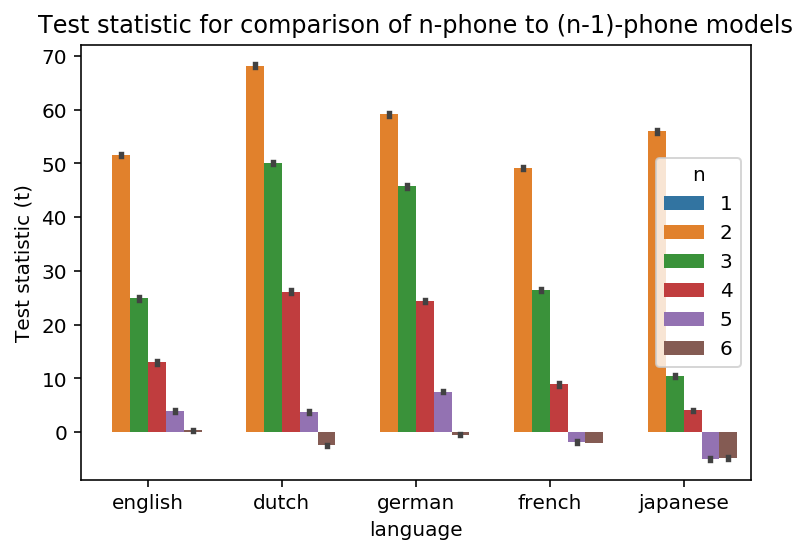

In [11]:
sns.barplot(data = df_results,
           x = 'language',
           y = 't',
           hue = 'n')

plt.ylabel("Test statistic (t)")
plt.title("Test statistic for comparison of n-phone to (n-1)-phone models")
plt.savefig("Figures/evaluation/t_test.png", dpi=300)

Text(0, 0.5, 'P-value for comparing n-phone to (n-1)-phone model')

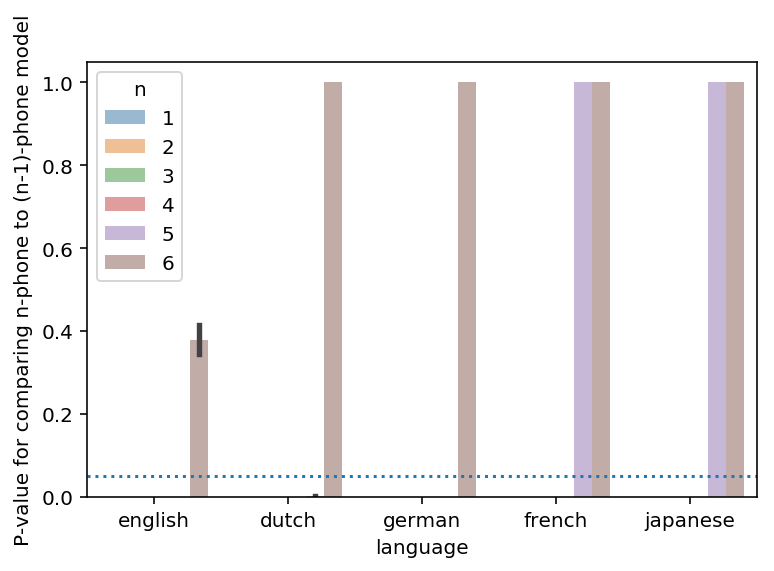

In [10]:
sns.barplot(data = df_results,
           x = 'language',
           y = 'p',
           hue = 'n',
               alpha = .5)

plt.axhline(y=.05, linestyle="dotted")

plt.ylabel("P-value for comparing n-phone to (n-1)-phone model")

Text(0, 0.5, 'Sum of log likelihoods for held-out wordforms')

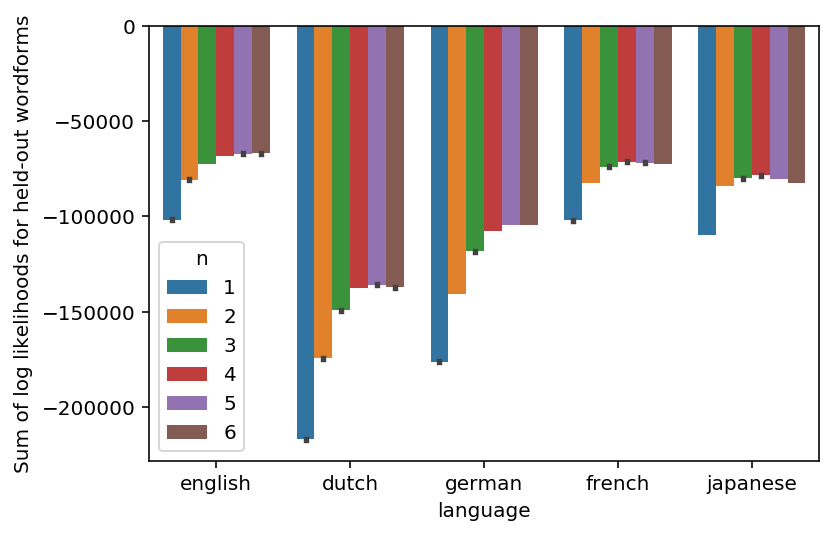

In [12]:
sns.barplot(data = df_results,
           x = 'language',
           y = 'sum_loglik',
           hue = 'n')

plt.ylabel("Sum of log likelihoods for held-out wordforms")

Text(0, 0.5, 'Mean log likelihood for held-out wordforms')

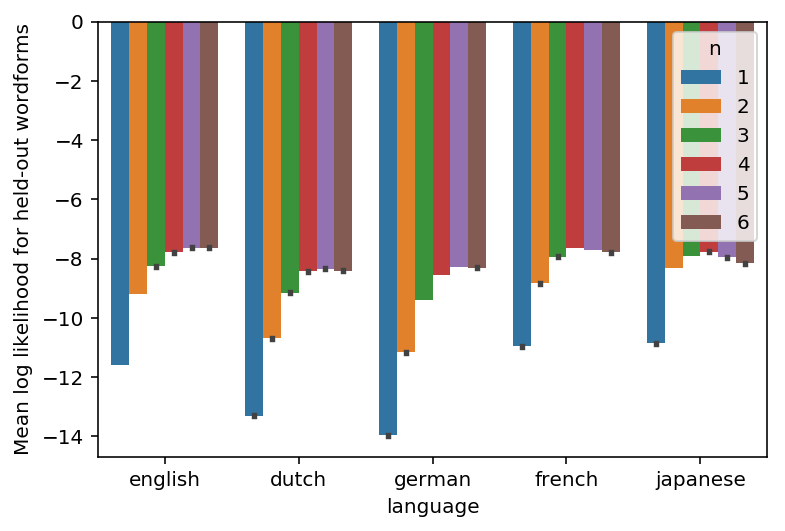

In [13]:
sns.barplot(data = df_results,
           x = 'language',
           y = 'mean_loglik',
           hue = 'n')

plt.ylabel("Mean log likelihood for held-out wordforms")

In [14]:
df_results['n'] = df_results['n'].apply(lambda x: str(x) + "-phone")

Text(0, 0.5, 'Mean log likelihood for held-out wordforms')

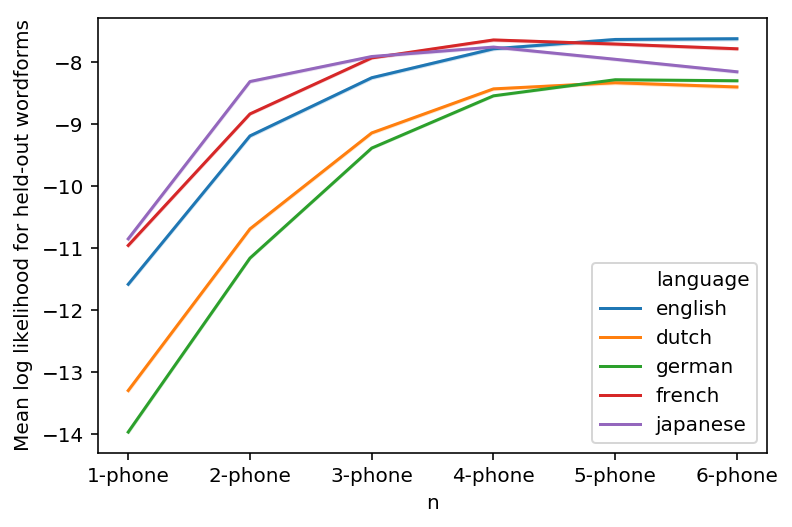

In [15]:
sns.lineplot(data = df_results,
           x = 'n',
           y = 'mean_loglik',
           hue = 'language')

plt.ylabel("Mean log likelihood for held-out wordforms")

Text(0, 0.5, 'Sum log likelihood for held-out wordforms')

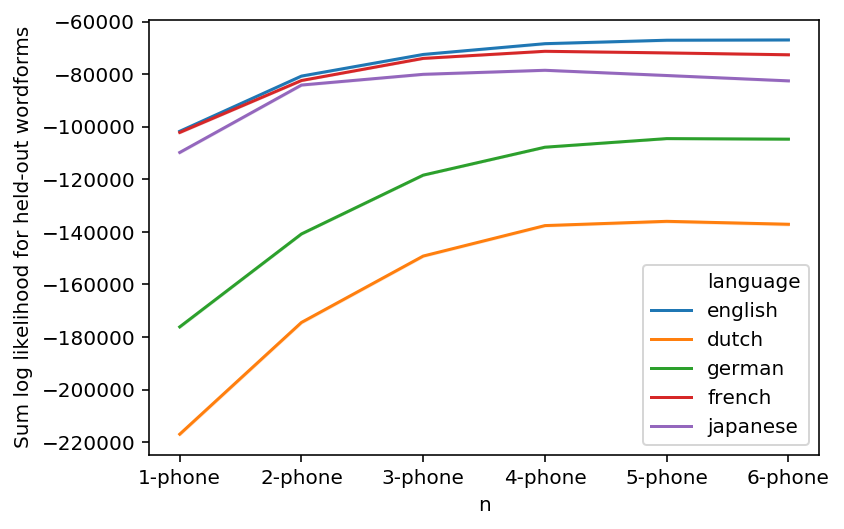

In [16]:
sns.lineplot(data = df_results,
           x = 'n',
           y = 'sum_loglik',
           hue = 'language')

plt.ylabel("Sum log likelihood for held-out wordforms")

In [17]:
df_results[['language', 'mean_loglik', 'n']].groupby(['language', 'n']).mean()

mean_loglik
language n                   
dutch    1-phone   -13.299344
         2-phone   -10.691853
         3-phone    -9.143211
         4-phone    -8.432488
         5-phone    -8.333036
         6-phone    -8.401506
english  1-phone   -11.584845
         2-phone    -9.191165
         3-phone    -8.252706
         4-phone    -7.785614
         5-phone    -7.635602
         6-phone    -7.623271
french   1-phone   -10.958153
         2-phone    -8.836463
         3-phone    -7.933015
         4-phone    -7.642873
         5-phone    -7.709098
         6-phone    -7.785303
german   1-phone   -13.969193
         2-phone   -11.162951
         3-phone    -9.387895
         4-phone    -8.544540
         5-phone    -8.284892
         6-phone    -8.301482
japanese 1-phone   -10.852005
         2-phone    -8.313951
         3-phone    -7.910288
         4-phone    -7.758229
         5-phone    -7.955058
         6-phone    -8.156512